In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
df = pd.read_csv('/content/T1.csv')

# Remove negative power
df['LV ActivePower (kW)'] = df['LV ActivePower (kW)'].clip(lower=0)

# Create class labels
df['Power Level'] = pd.qcut(df['LV ActivePower (kW)'], q=3, labels=['Low','Medium','High'])

# Feature selection
X = df[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']]
y = df['Power Level']

# Encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
def create_sequences(X, y, window=6):
    Xs, ys = [], []
    for i in range(len(X)-window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

window = 6
X_seq, y_seq = create_sequences(X, y, window)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

y_train_cat = to_categorical(y_train_seq, num_classes=3)
y_test_cat = to_categorical(y_test_seq, num_classes=3)

In [13]:
cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(window, 3)),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=2, activation='relu'),
    Flatten(), # Removed the second MaxPooling1D layer
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

cnn.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train_seq, y_train_cat, epochs=25, batch_size=64,
        validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8076 - loss: 0.5040 - val_accuracy: 0.8669 - val_loss: 0.3625
Epoch 2/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8774 - loss: 0.3385 - val_accuracy: 0.8736 - val_loss: 0.3487
Epoch 3/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8792 - loss: 0.3343 - val_accuracy: 0.8699 - val_loss: 0.3422
Epoch 4/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8793 - loss: 0.3294 - val_accuracy: 0.8765 - val_loss: 0.3389
Epoch 5/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8842 - loss: 0.3207 - val_accuracy: 0.8753 - val_loss: 0.3396
Epoch 6/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8815 - loss: 0.3203 - val_accuracy: 0.8738 - val_loss: 0.3388
Epoch 7/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8850 - loss: 0.3148 - val_accuracy: 0.8761 - val_loss: 0.3323
Epoch 8/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8817 - loss: 0.3205 - val_accuracy: 0.8770 - val_

In [14]:
lstm = Sequential([
    LSTM(64, input_shape=(window,3)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

lstm.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lstm.fit(X_train_seq, y_train_cat, epochs=25, batch_size=64,
         validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7790 - loss: 0.5450 - val_accuracy: 0.8516 - val_loss: 0.3878
Epoch 2/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8681 - loss: 0.3637 - val_accuracy: 0.8706 - val_loss: 0.3578
Epoch 3/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8745 - loss: 0.3514 - val_accuracy: 0.8696 - val_loss: 0.3492
Epoch 4/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8784 - loss: 0.3413 - val_accuracy: 0.8736 - val_loss: 0.3512
Epoch 5/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8821 - loss: 0.3315 - val_accuracy: 0.8790 - val_loss: 0.3437
Epoch 6/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8828 - loss: 0.3291 - val_accuracy: 0.8765 - val_loss: 0.3343
Epoch 7/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8866 - loss: 0.3281 - val_accuracy: 0.8748 - val_loss: 0.3399
Epoch 8/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8868 - loss: 0.3195 - val_accuracy: 0.8790 - val_

In [15]:
bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(window,3)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

bilstm.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

bilstm.fit(X_train_seq, y_train_cat, epochs=25, batch_size=64,
           validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8038 - loss: 0.4982 - val_accuracy: 0.8691 - val_loss: 0.3556
Epoch 2/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8737 - loss: 0.3480 - val_accuracy: 0.8731 - val_loss: 0.3477
Epoch 3/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8763 - loss: 0.3385 - val_accuracy: 0.8763 - val_loss: 0.3441
Epoch 4/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8800 - loss: 0.3306 - val_accuracy: 0.8748 - val_loss: 0.3400
Epoch 5/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8812 - loss: 0.3302 - val_accuracy: 0.8731 - val_loss: 0.3473
Epoch 6/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8822 - loss: 0.3305 - val_accuracy: 0.8746 - val_loss: 0.3344
Epoch 7/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8806 - loss: 0.3287 - val_accuracy: 0.8761 - val_loss: 0.3345
Epoch 8/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8865 - loss: 0.3182 - val_accuracy: 0.8751 - v

In [16]:
cnn_lstm = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(window,3)),
    MaxPooling1D(2),
    LSTM(50),
    Dense(3, activation='softmax')
])

cnn_lstm.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm.fit(X_train_seq, y_train_cat, epochs=25, batch_size=64,
             validation_split=0.1, callbacks=[EarlyStopping(patience=5)])

Epoch 1/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7713 - loss: 0.5646 - val_accuracy: 0.8563 - val_loss: 0.3757
Epoch 2/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8721 - loss: 0.3552 - val_accuracy: 0.8684 - val_loss: 0.3650
Epoch 3/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8773 - loss: 0.3424 - val_accuracy: 0.8681 - val_loss: 0.3538
Epoch 4/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8775 - loss: 0.3400 - val_accuracy: 0.8741 - val_loss: 0.3465
Epoch 5/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8818 - loss: 0.3292 - val_accuracy: 0.8701 - val_loss: 0.3472
Epoch 6/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8817 - loss: 0.3263 - val_accuracy: 0.8726 - val_loss: 0.3454
Epoch 7/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8785 - loss: 0.3268 - val_accuracy: 0.8736 - val_loss: 0.3366
Epoch 8/25
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8845 - loss: 0.3161 - val_accuracy: 0.

In [17]:
def evaluate_dl(model, name):
    pred = model.predict(X_test_seq)
    y_pred = np.argmax(pred, axis=1)
    print(f"\n{name} Accuracy:", accuracy_score(y_test_seq, y_pred))
    print(classification_report(y_test_seq, y_pred))

evaluate_dl(cnn, "CNN")
evaluate_dl(lstm, "LSTM")
evaluate_dl(bilstm, "BiLSTM")
evaluate_dl(cnn_lstm, "CNN-LSTM")

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

CNN Accuracy: 0.8821375556655121
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3369
           1       0.93      0.85      0.89      3369
           2       0.84      0.86      0.85      3367

    accuracy                           0.88     10105
   macro avg       0.88      0.88      0.88     10105
weighted avg       0.88      0.88      0.88     10105

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM Accuracy: 0.8835230084116774
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3369
           1       0.95      0.83      0.89      3369
           2       0.82      0.88      0.85      3367

    accuracy                           0.88     10105
   macro avg       0.89      0.88      0.88     10105
weighted avg       0.89      0.88      0.88     10105

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

BiLSTM Accuracy: 0.8839188520534389
         

In [18]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("\nSVM Accuracy:", svm.score(X_test, y_test))
print("KNN Accuracy:", knn.score(X_test, y_test))


SVM Accuracy: 0.9334058974866416
KNN Accuracy: 0.9285572926974075


316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


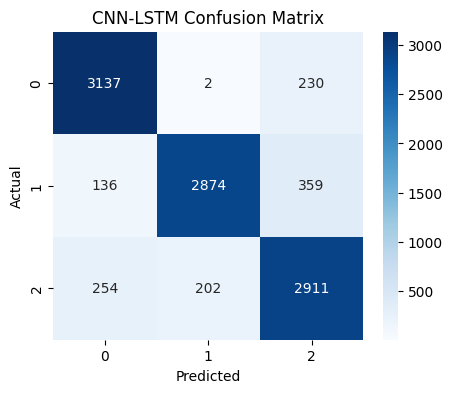

In [19]:
import seaborn as sns

y_pred = np.argmax(cnn_lstm.predict(X_test_seq), axis=1)
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()